# Tutorial 7a - Design of a Lithographic Projection System

### August 2024

This tutorial demonstrates how Optiland can be used to analyze and optimize a lithographic projection lens. The starting point for this design is based on U.S. Patent #5831776.

In [1]:
import numpy as np

from optiland import analysis, materials, mtf, optic, optimization, wavefront

The lens is designed for a wavelength of 248 nm and only uses silica lenses. Note that the lens is telecentric in object space. This only forces the chief ray in object space to be parallel with the optical axis. It does not directly enforce that the chief ray passes through the center of the aperture stop.

In [ ]:
lens = optic.Optic()

# We define SiO2 with the index of refraction at 248 nm
SiO2 = materials.IdealMaterial(n=1.5084, k=0)

# Define all surfaces
lens.add_surface(index=0, radius=np.inf, thickness=110.85883544)
lens.add_surface(index=1, radius=-737.7847, thickness=27.484, material=SiO2)
lens.add_surface(index=2, radius=-235.2891, thickness=0.916)
lens.add_surface(index=3, radius=211.1786, thickness=36.646, material=SiO2)
lens.add_surface(index=4, radius=-461.3986, thickness=0.916)
lens.add_surface(index=5, radius=412.6778, thickness=21.071, material=SiO2)
lens.add_surface(index=6, radius=160.5391, thickness=16.197)
lens.add_surface(index=7, radius=-604.1283, thickness=7.215, material=SiO2)
lens.add_surface(index=8, radius=218.1877, thickness=23.941)
lens.add_surface(index=9, radius=-3586.063, thickness=11.978, material=SiO2)
lens.add_surface(index=10, radius=251.8168, thickness=47.506)
lens.add_surface(index=11, radius=-85.2817, thickness=11.961, material=SiO2)
lens.add_surface(index=12, radius=584.8597, thickness=9.968)
lens.add_surface(index=13, radius=4074.801, thickness=35.291, material=SiO2)
lens.add_surface(index=14, radius=-162.0185, thickness=0.923)
lens.add_surface(index=15, radius=629.544, thickness=41.227, material=SiO2)
lens.add_surface(index=16, radius=-226.7397, thickness=0.916)
lens.add_surface(index=17, radius=522.2739, thickness=27.842, material=SiO2)
lens.add_surface(index=18, radius=-582.424, thickness=0.916)
lens.add_surface(index=19, radius=423.729, thickness=22.904, material=SiO2)
lens.add_surface(index=20, radius=-1385.36, thickness=0.916, is_stop=True)
lens.add_surface(index=21, radius=212.039, thickness=33.646, material=SiO2)
lens.add_surface(index=22, radius=802.3695, thickness=55.304)
lens.add_surface(index=23, radius=-776.5697, thickness=8.703, material=SiO2)
lens.add_surface(index=24, radius=106.1728, thickness=24.09)
lens.add_surface(index=25, radius=-200.683, thickness=11.452, material=SiO2)
lens.add_surface(index=26, radius=311.8264, thickness=59.54)
lens.add_surface(index=27, radius=-77.2276, thickness=11.772, material=SiO2)
lens.add_surface(index=28, radius=2317.8032, thickness=11.862)
lens.add_surface(index=29, radius=-290.8859, thickness=22.904, material=SiO2)
lens.add_surface(index=30, radius=-148.3577, thickness=1.373)
lens.add_surface(index=31, radius=-5658.5043, thickness=41.227, material=SiO2)
lens.add_surface(index=32, radius=-151.9858, thickness=0.916)
lens.add_surface(index=33, radius=678.1005, thickness=32.981, material=SiO2)
lens.add_surface(index=34, radius=-358.554, thickness=0.916)
lens.add_surface(index=35, radius=264.2734, thickness=32.814, material=SiO2)
lens.add_surface(index=36, radius=2309.6884, thickness=0.916)
lens.add_surface(index=37, radius=171.2681, thickness=29.015, material=SiO2)
lens.add_surface(index=38, radius=364.7765, thickness=0.918)
lens.add_surface(index=39, radius=113.37, thickness=76.259, material=SiO2)
lens.add_surface(index=40, radius=78.6982, thickness=54.304)
lens.add_surface(index=41, radius=49.5443, thickness=18.65, material=SiO2)
lens.add_surface(index=42, radius=109.8136, thickness=13.07647896)
lens.add_surface(index=43, radius=np.inf)

# Define the aperture (the original NA was 0.15, but we reduce it slightly to avoid
# negative edge thicknesses)
lens.set_aperture(aperture_type="objectNA", value=0.133)

# Define the field
lens.set_field_type(field_type="object_height")
lens.add_field(y=0)
lens.add_field(y=32)
lens.add_field(y=48)

# Define the wavelength
lens.add_wavelength(value=0.248, is_primary=True)

# Specify that the lens is object-space telecentric
lens.obj_space_telecentric = True

# Move last surface to the paraxial image plane
lens.image_solve()

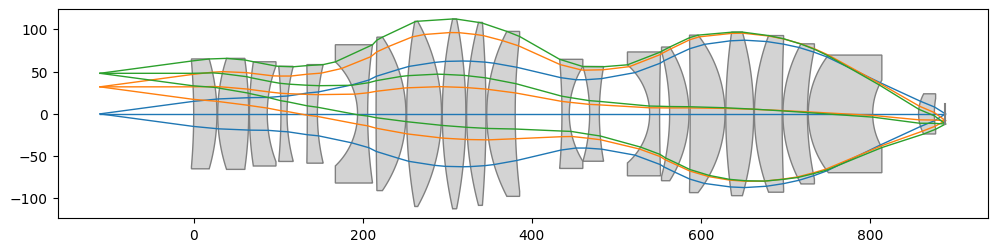

In [3]:
lens.draw(figsize=(12, 3))

1. Initial Performance Assessment

Let's see how close the lens is to diffraction-limited by plotting the MTF:

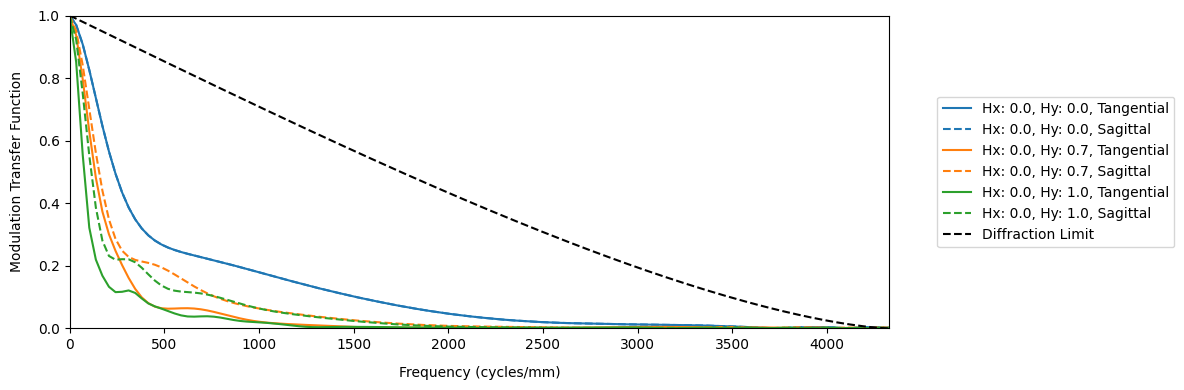

In [4]:
lens_mtf = mtf.FFTMTF(lens)
lens_mtf.view(add_reference=True)

Clearly, the lens is far from the diffraction limit.

2. Optimization

We now wish to make the lens diffraction-limited. Let's optimize the imaging performance by allowing all lens radii to vary.

In [5]:
problem = optimization.OptimizationProblem()

# Add focal length operand
problem.add_operand(operand_type="f2", target=494, weight=1, input_data={"optic": lens})

# Add OPD operands for imaging quality
for field in lens.fields.get_field_coords():
    input_data = {
        "optic": lens,
        "Hx": field[0],
        "Hy": field[1],
        "num_rays": 5,
        "wavelength": 0.248,
        "distribution": "gaussian_quad",
    }
    problem.add_operand(
        operand_type="OPD_difference",
        target=0,
        weight=10,
        input_data=input_data,
    )

# Allow the radii of curvature of all surfaces to vary
for k in range(1, lens.surface_group.num_surfaces - 1):
    problem.add_variable(
        lens,
        "radius",
        surface_number=k,
        min_val=-10000,
        max_val=10000,
    )

# Print current merit function value
problem.merit_info()

+----+------------------------+-------------------+
|    |   Merit Function Value |   Improvement (%) |
|----+------------------------+-------------------|
|  0 |                12.5476 |                 0 |
+----+------------------------+-------------------+


We now run the standard optimizer. Note that this may take several minutes for a termination tolerance of 1e-9, but this should result in a high-performing lens.

In [6]:
optimizer = optimization.OptimizerGeneric(problem)
res = optimizer.optimize(tol=1e-9)

Printing the merit function result, we can see an improvement of ≈98%.

In [7]:
problem.merit_info()

+----+------------------------+-------------------+
|    |   Merit Function Value |   Improvement (%) |
|----+------------------------+-------------------|
|  0 |                0.18312 |           98.5406 |
+----+------------------------+-------------------+


Let's again view the MTF:

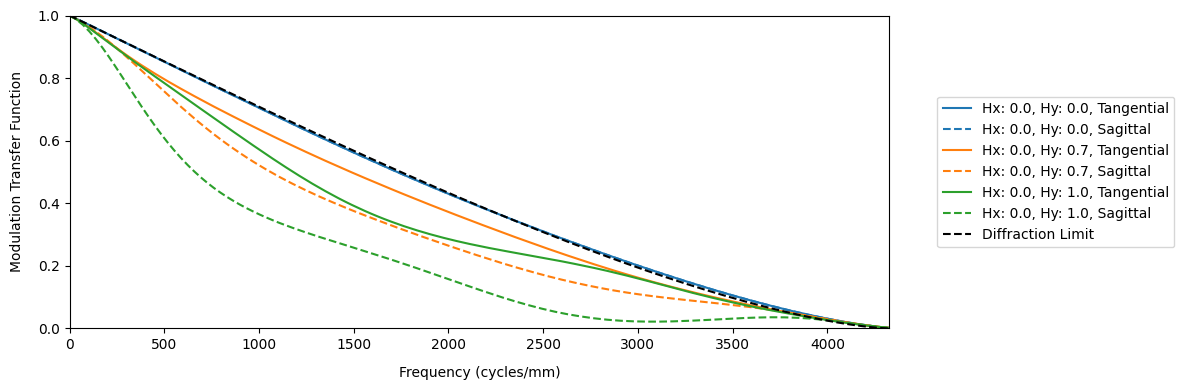

In [8]:
lens_mtf = mtf.FFTMTF(lens)
lens_mtf.view(add_reference=True)

This is a significant improvement over the initial design. We plot the diffraction limit as a reference.

3. Final Performance Assessment

Let's generate a few visualizations to show the final performance of the system. We will compute:

- Wavefront OPD map for the (Hx, Hy) = (0, 1) field & corresponding standard Zernike coefficients
- Standard spot diagram
- Ray aberration fans

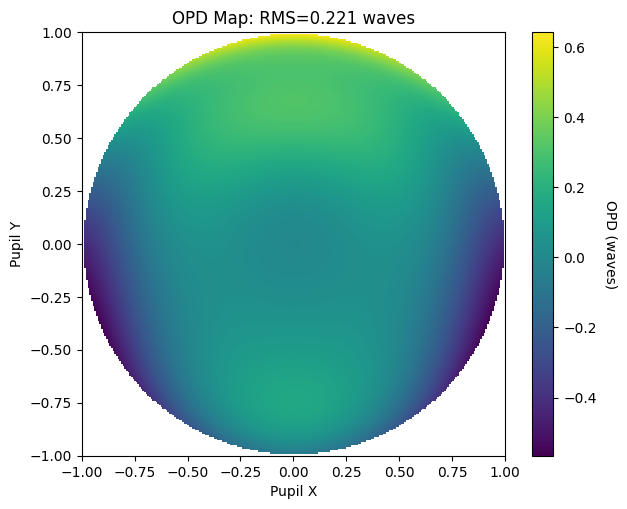

In [9]:
opd = wavefront.OPD(lens, field=(0, 1), wavelength=0.248)
opd.view(projection="2d", num_points=256)

In [10]:
print("Zernike Standard Coefficients:")
zernike = wavefront.ZernikeOPD(
    lens,
    (0, 1),
    0.55,
    zernike_type="standard",
    num_terms=21,
)

for k in range(len(zernike.coeffs)):
    print(f"\tZ{k + 1}: {zernike.coeffs[k]:.8f}")

Zernike Standard Coefficients:
	Z1: 0.01735758
	Z2: -0.05168029
	Z3: -0.00000000
	Z4: -0.00000000
	Z5: -0.01909300
	Z6: -0.06172758
	Z7: -0.01506762
	Z8: -0.01705757
	Z9: -0.00000000
	Z10: -0.00000000
	Z11: -0.00000000
	Z12: 0.00000000
	Z13: -0.01240470
	Z14: -0.00315813
	Z15: -0.00200293
	Z16: -0.00086635
	Z17: 0.00089715
	Z18: -0.01099649
	Z19: 0.00000000
	Z20: 0.00000000
	Z21: 0.00000000


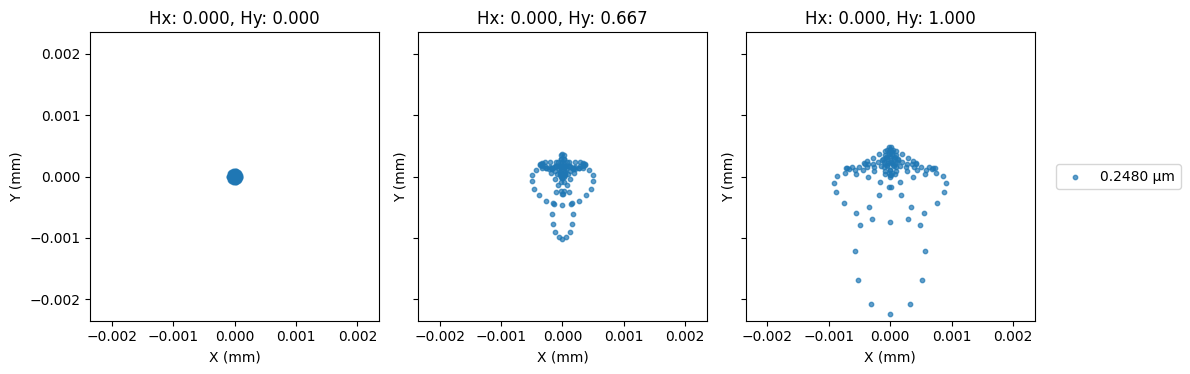

In [11]:
spot = analysis.SpotDiagram(lens)
spot.view()

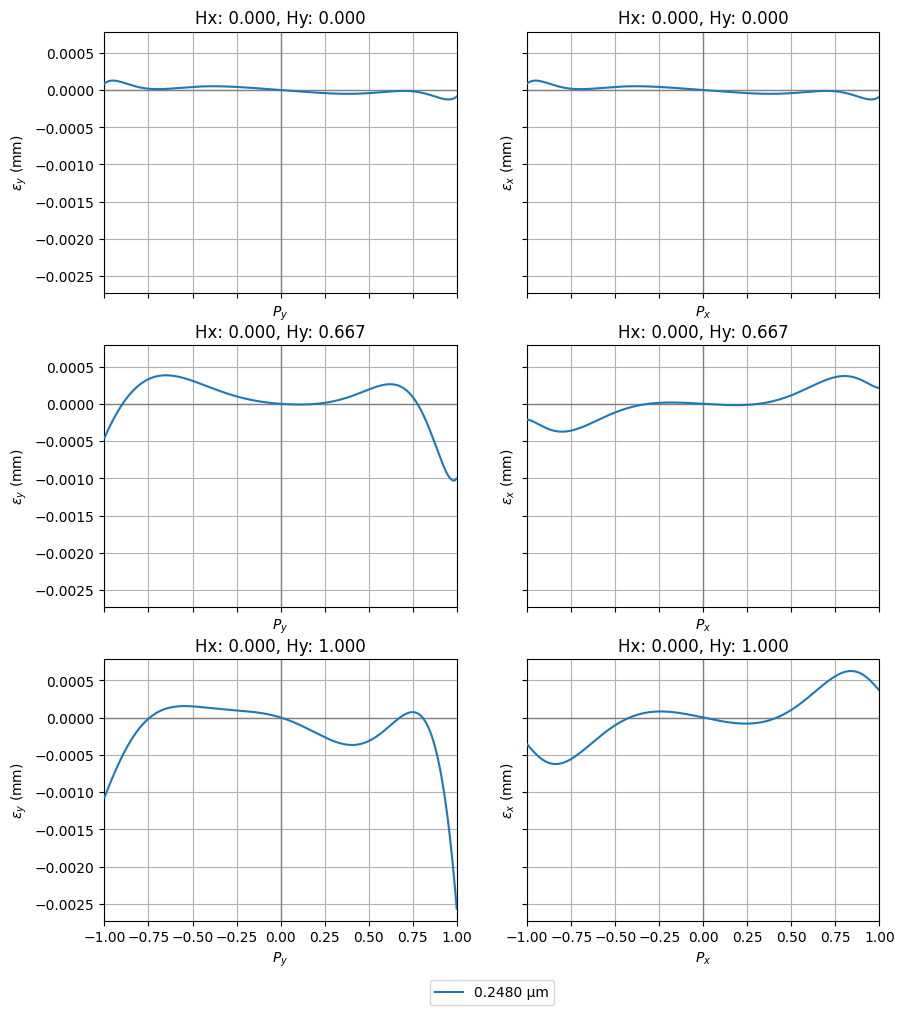

In [12]:
fan = analysis.RayFan(lens)
fan.view()

4. Conclusions:

- Starting from a patent design, we optimized a lithographic projection lens to achieve near diffraction-limited performance
- While significantly improved, the final design still has room for improvement. For example, we could have introduced aspheres on some of the surfaces.

As a reference, we print the final optimized lens data:

In [15]:
lens.info()

+----+----------+------------+-------------+------------+---------+-----------------+
|    | Type     |     Radius |   Thickness | Material   |   Conic |   Semi-aperture |
|----+----------+------------+-------------+------------+---------+-----------------|
|  0 | Planar   |   inf      |    110.859  | Air        |       0 |         48      |
|  1 | Standard |  -737.785  |     27.484  | 1.5084     |       0 |         62.8764 |
|  2 | Standard |  -235.279  |      0.916  | Air        |       0 |         63.7129 |
|  3 | Standard |   211.148  |     36.646  | 1.5084     |       0 |         63.6289 |
|  4 | Standard |  -461.394  |      0.916  | Air        |       0 |         57.6775 |
|  5 | Standard |   412.675  |     21.071  | 1.5084     |       0 |         57.3949 |
|  6 | Standard |   160.56   |     16.197  | Air        |       0 |         52.0974 |
|  7 | Standard |  -604.128  |      7.215  | 1.5084     |       0 |         48.6269 |
|  8 | Standard |   218.198  |     23.941  | Air      